In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

import configparser
config = configparser.ConfigParser()
config.read('config.ini')

#import wandb
#from wandb.keras import WandbCallback
#wandb.login()

#run = wandb.init(project="basic-nn-tensorflow", id="lr-scheduler-adam-bce-cos-deeper")
#wandb.config.update(config)

2.9.2
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


['config.ini']

In [2]:
data_path = 'Data/raw-img'

class_names = sorted(os.listdir(data_path))
num_classes = len(class_names)
print("Number of Classes:", num_classes)

class_sizes = []
for name in class_names:
    class_size = len(os.listdir(data_path + "/" + name))
    class_sizes.append(class_size)

print("Class Distribution:\n", dict(zip(class_names, class_sizes)))

Number of Classes: 10
Class Distribution:
 {'butterfly': 2112, 'cat': 1668, 'chicken': 3098, 'cow': 1866, 'dog': 4863, 'elephant': 1446, 'horse': 2623, 'sheep': 1820, 'spider': 4821, 'squirrel': 1862}


In [6]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    validation_split=0.2)

train_data = data_generator.flow_from_directory(
    data_path,
    target_size=(128,128),
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    subset='training')

valid_data = data_generator.flow_from_directory(
    data_path,
    target_size=(128,128),
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    subset='validation')

Found 20947 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.


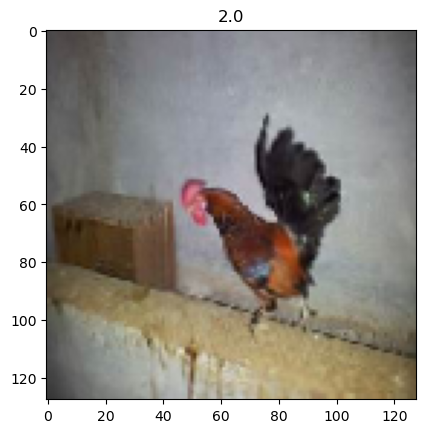

In [7]:
for images, labels in iter(train_data):
    plt.imshow(images[20])
    plt.title(labels[20])
    break

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, 3, input_shape=[128, 128, 3], padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu"),
    tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu"),
    tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(512, 3, padding="same", activation="relu"),
    tf.keras.layers.Conv2D(512, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation="softmax")
])

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 256)      

In [9]:
model.fit(train_data, validation_data=valid_data, epochs=config['default'].getint('epochs'))

Epoch 1/5


2023-04-03 09:27:39.587467: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-03 09:27:39.854700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


655/655 [==============================] - ETA: 0s - loss: 451.5729 - accuracy: 0.1801

2023-04-03 09:31:43.426389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


655/655 [==============================] - 262s 393ms/step - loss: 451.5729 - accuracy: 0.1801 - val_loss: 2.2085 - val_accuracy: 0.1858
Epoch 2/5
655/655 [==============================] - 262s 399ms/step - loss: 2.2091 - accuracy: 0.1830 - val_loss: 2.2094 - val_accuracy: 0.1843
Epoch 3/5
655/655 [==============================] - 275s 419ms/step - loss: 2.2091 - accuracy: 0.1879 - val_loss: 2.2084 - val_accuracy: 0.1843
Epoch 4/5
655/655 [==============================] - 266s 406ms/step - loss: 2.2089 - accuracy: 0.1835 - val_loss: 2.2079 - val_accuracy: 0.1858
Epoch 5/5
655/655 [==============================] - 259s 396ms/step - loss: 2.2085 - accuracy: 0.1836 - val_loss: 2.2091 - val_accuracy: 0.1858


In [16]:
pd.DataFrame(model.history.history)

,loss,accuracy,val_loss,val_accuracy
0,451.572876,0.180074,2.208485,0.185780
1,2.209138,0.182986,2.209383,0.184251
2,2.209100,0.187903,2.208402,0.184251
3,2.208910,0.183463,2.207936,0.185780
4,2.208519,0.183559,2.209117,0.185780
